In [1]:
import EddyDetectionV2 as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.patheffects as pe

In [2]:
from pathlib import Path

def get_file_size(file_path):
    file_size_bytes = Path(file_path).stat().st_size
    if file_size_bytes < 1024:
        return f"{file_size_bytes} B"
    elif file_size_bytes < 1024**2:
        return f"{file_size_bytes / 1024:.2f} KB"
    elif file_size_bytes < 1024**3:
        return f"{file_size_bytes / 1024**2:.2f} MB"
    else:
        return f"{file_size_bytes / 1024**3:.2f} GB"

file_path = '/nird/projects/NS9608K/MSc_EK/Data/EddyResults/Tracking/EddyAreaID.nc'
print(f"File size: {get_file_size(file_path)}")

import netCDF4 as nc

# Open NetCDF file using netCDF4
ds_nc = nc.Dataset('/nird/projects/NS9608K/MSc_EK/Data/EddyResults/Tracking/EddyAreaID.nc')

# Extract variable data excluding coordinates
data_vars = {}
for var_name, nc_var in ds_nc.variables.items():
    if var_name not in ds_nc.dimensions:
        data_vars[var_name] = (nc_var.dimensions, np.array(nc_var))

# Extract coordinate data
coords = {}
for coord_name, nc_coord in ds_nc.dimensions.items():
    coords[coord_name] = np.array(ds_nc.variables[coord_name])

# Extract global attributes
attrs = {attr: ds_nc.getncattr(attr) for attr in ds_nc.ncattrs()}

# Create xarray Dataset with extracted information
ds_xr = xr.Dataset(data_vars=data_vars, coords=coords, attrs=attrs)

# Display the converted xarray.Dataset
print(ds_xr)

JMREI = ds_xr['EddyID'].sel(Y=slice(71, 74), X=slice(-18, -7))
display(JMREI)

File size: 2.26 GB
<xarray.Dataset> Size: 346MB
Dimensions:  (Y: 231, X: 510, time: 365)
Coordinates:
  * X        (X) float64 4kB -21.98 -21.93 -21.87 -21.82 ... 1.879 1.936 1.994
  * Y        (Y) float64 2kB 70.01 70.03 70.04 70.06 ... 74.89 74.92 74.95 74.99
  * time     (time) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Data variables:
    XC       (Y, X) float64 942kB -21.98 -21.93 -21.87 ... 1.879 1.936 1.994
    YC       (Y, X) float64 942kB 70.01 70.01 70.01 70.01 ... 74.99 74.99 74.99
    Z        float64 8B -1.0
    EddyID   (time, Y, X) object 344MB '0' '0' '0' '0' '0' ... '0' '0' '0' '0'


<xarray.DataArray 'EddyID' (time: 365, Y: 139, X: 248)> Size: 101MB
array([[['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ...,
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0']],

       [['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ...,
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0']],

       [['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ...,
...
        ...,
        ['0', '0', '0', ..., "['3084']", '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0']],

       [['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ...,
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0']],

       [['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ...,
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0']]], dtype=object)
Coordinates:
  * X        (X) float64 2kB -17.99 -17.94 -17.9 -17.85 ... -7.129 -7.085 -7.041
  * Y        (Y) float64 1kB 71.01 71.03 71.04 71.06 ... 73.9 73.93 73.95 73.98
  * time     (time) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364

In [3]:
JMFZ_region = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWT/JMFZFWT.nc')['shelfExtended'].assign_attrs(
    units="mSv", description="Freshwater transport"
).rename('FWT_70_74N')
eddyRegion = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Eddies_fullYear.nc')['EddyDetection'].sel(Y=slice(71,74),X=slice(-18,-7))
eddyRegion.attrs = {}
eddyRegion = eddyRegion.assign_attrs(
    unit="Eddy type (1 == anti-cyclonic, 2 == cyclonic)", description="Outermost closed SSH defined eddy region"
)

depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(71,74),X=slice(-18,-7))
depth_no_nan = depth

depth = depth.where(depth > 0, np.nan)

FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(71,74)).sel(X=slice(-18,-7))
FWC = FWC.resample(time='D').mean(dim='time').rename('FWC')

area = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/rA.nc')['rA'].sel(Y=slice(71,74),X=slice(-18,-7))

FWT_restructure = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/FWT/JMFZFWT_regrid.nc')['Jan Mayen region FWT']

In [4]:
locMax_surf = pd.read_csv('/nird/projects/NS9608K/MSc_EK/Data/EddyResults/Tracking/locMAX.csv')
locMin_surf = pd.read_csv('/nird/projects/NS9608K/MSc_EK/Data/EddyResults/Tracking/locMin.csv')

eddies_ID_max_t = locMax_surf.set_index(['Time'])
eddies_ID_min_t = locMin_surf.set_index(['Time'])

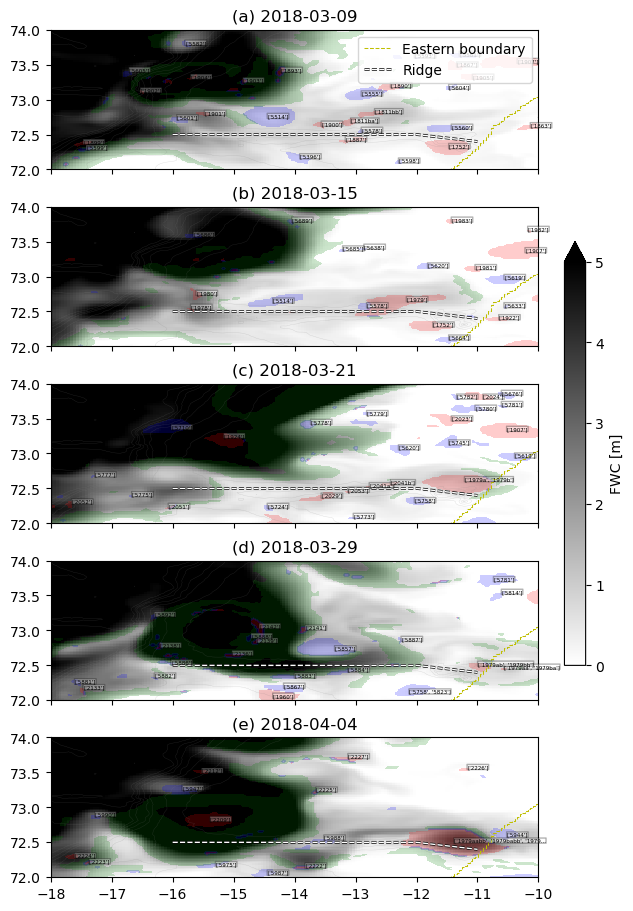

In [31]:
fig, (ax,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,sharey=True,
    figsize=(6.2217,9),layout='constrained'
) 


lon = depth['XC']
lat = depth['YC']
land = depth_no_nan.where(depth_no_nan==0)

# Subplot1
time = 184+5

mesh = ax.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)
cbar = fig.colorbar(mesh,ax=[ax,ax2,ax3,ax4,ax5], shrink=0.5,pad=0.01,extend='max')
cbar.set_label('FWC [m]')

ax.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax.set_ylim(72,74)
ax.set_xlim(-18,-10)
ax.set_title('(a) '+ str(FWC[time].time.values)[0:10])
ax.legend(loc='upper right')

# Subplot2
time = 184+5+6

ax2.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)

ax2.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax2.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax2.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax2.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax2.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax2.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax2.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax2.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax2.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax2.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax2.set_title('(b) '+ str(FWC[time].time.values)[0:10])

# Subplot3
time = 184+5+6+6

ax3.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)

ax3.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax3.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax3.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax3.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax3.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax3.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax3.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax3.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax3.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax3.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax3.set_title('(c) '+ str(FWC[time].time.values)[0:10])

# Subplot4
time = 184+5+6+6+8

ax4.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)

ax4.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax4.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax4.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax4.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax4.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax4.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax4.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax4.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax4.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax4.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax4.set_title('(d) '+ str(FWC[time].time.values)[0:10])

# Subplot4
time = 184+5+6+6+8+6

ax5.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)

ax5.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax5.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax5.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax5.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax5.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax5.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax5.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax5.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax5.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax5.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax5.set_title('(e) '+ str(FWC[time].time.values)[0:10])

fig.savefig(f'/nird/home/ekv036/MSc/Fig/EddyTracking/Case1',dpi=500, facecolor='w', edgecolor='w',
            orientation='landscape', format=None,
            transparent=False, bbox_inches=None,pad_inches=0.25)

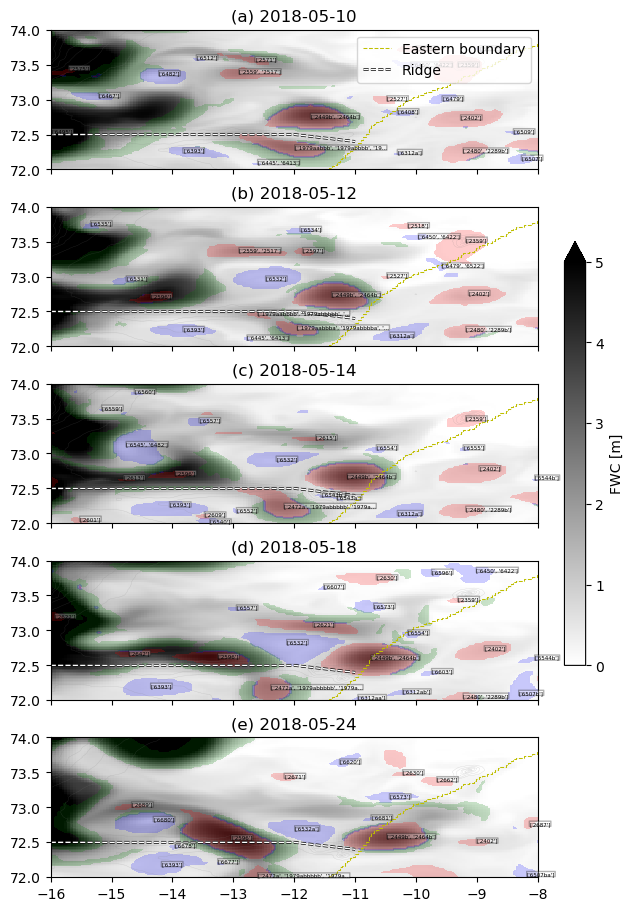

In [39]:
fig, (ax,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,sharey=True,
    figsize=(6.2217,9),layout='constrained'
) 


lon = depth['XC']
lat = depth['YC']
land = depth_no_nan.where(depth_no_nan==0)

# Subplot1
time = 251

mesh = ax.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)
cbar = fig.colorbar(mesh,ax=[ax,ax2,ax3,ax4,ax5], shrink=0.5,pad=0.01,extend='max')
cbar.set_label('FWC [m]')

ax.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax.set_ylim(72,74)
ax.set_xlim(-16,-8)
ax.set_title('(a) '+ str(FWC[time].time.values)[0:10])
ax.legend(loc='upper right')

# Subplot2
time = 251+2

ax2.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)

ax2.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax2.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax2.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax2.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax2.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax2.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax2.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax2.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax2.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax2.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax2.set_title('(b) '+ str(FWC[time].time.values)[0:10])

# Subplot3
time = 251+2+2

ax3.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)

ax3.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax3.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax3.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax3.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax3.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax3.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax3.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax3.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax3.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax3.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax3.set_title('(c) '+ str(FWC[time].time.values)[0:10])

# Subplot4
time = 251+2+2+4

ax4.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)

ax4.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax4.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax4.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax4.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax4.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax4.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax4.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax4.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax4.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax4.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax4.set_title('(d) '+ str(FWC[time].time.values)[0:10])

# Subplot4
time = 251+2+2+4+6

ax5.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='binary',vmin=0,vmax=5,zorder=0)

ax5.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100,zorder=0)

# Add land contour
ax5.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.25,zorder=0)
ax5.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.25,alpha=0.3)

# Eastern boundary
ax5.plot(JMFZ_region.XC,JMFZ_region.YC,linestyle='--',color='y',linewidth=0.75,label='Eastern boundary')

# Ridge
ax5.plot([-16,-15,-14,-13,-12,-11],[72.5,72.5,72.5,72.5,72.5,72.4],linestyle='--',color='white',label='Ridge',linewidth=1,path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

# Eddies
ax5.contourf(eddyRegion.X.sel(X=slice(-18,-7)),eddyRegion.Y.sel(Y=slice(71,74)),eddyRegion[time].sel(X=slice(-18,-7),Y=slice(71,74)),[0.5,1.5,3.5,4.5],colors=['red','blue','green'],alpha=0.2)


# ID
ID_max_lon = eddies_ID_max_t.at[time,'Longitude'].values
ID_max_lat = eddies_ID_max_t.at[time,'Latitude'].values
ID_max = eddies_ID_max_t.at[time,'ID'].values

#display(ID_max,ID_max_lon,ID_max_lat)

for data in range(len(ID_max)):
    if -18 <= ID_max_lon[data] <= -7 and 71 <= ID_max_lat[data] <= 74:
        if len(str(ID_max[data])) < 30:
            ax5.annotate(ID_max[data],xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax5.annotate(str(ID_max[data])[0:30]+'...',xy=[ID_max_lon[data],ID_max_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ID_min_lon = eddies_ID_min_t.at[time,'Longitude'].values
ID_min_lat = eddies_ID_min_t.at[time,'Latitude'].values
ID_min = eddies_ID_min_t.at[time,'ID'].values

for data in range(len(ID_min)):
    if -18 <= ID_min_lon[data] <= -7 and 71 <= ID_min_lat[data] <= 74:
        if len(str(ID_min[data])) < 30:
            ax5.annotate(ID_min[data],xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )
        else:
            ax5.annotate(str(ID_min[data])[0:30] + '...',xy=[ID_min_lon[data],ID_min_lat[data]],fontsize=4,
                        bbox=dict(boxstyle='round,pad=0.01', facecolor='white', alpha=0.3)
                        )

ax5.set_title('(e) '+ str(FWC[time].time.values)[0:10])

fig.savefig(f'/nird/home/ekv036/MSc/Fig/EddyTracking/Case2',dpi=500, facecolor='w', edgecolor='w',
            orientation='landscape', format=None,
            transparent=False, bbox_inches=None,pad_inches=0.25)